# Overview

In the notebook:
- data cleaning - entails handling of missing values (if any) and hot-encoding of categorical variables
- data exploration - entails investigating the correlation of all the variables (age, country, ...) with the user conversion
- modeling - entails training and testing a Logistic Regression model. The model is 5-fold cross-validated.
- conclusions - entails suggestions drawn from the exploration part.
The metric used to determine the best model is "Recall".

I load all the libraries I am going to use in the notebook:

In [474]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

# Cleaning

I upload the dataset into a pandas dataframe.
I then check the data types of the columns (I will have to hot-encode non-numerical columns)
and the percentage of missing values (NaN) in the columns.

In [475]:
data = pd.read_csv("./conversion_data.csv")

#print data types and percentage of NaN in columns
print(data.dtypes)
for col in data:
    sum_nan = data[col].isnull().sum()
    print(col, sum_nan/len(data[col])*100, ' %')

country                object
age                     int64
new_user                int64
source                 object
total_pages_visited     int64
converted               int64
dtype: object
country 0.0  %
age 0.0  %
new_user 0.0  %
source 0.0  %
total_pages_visited 0.0  %
converted 0.0  %


There are no Nan values, so I don't have to worry about them.
I proceed with exploration that might suggest some more cleaning.

# Exploration


I check the relationship between the variables I think might be correlated:
- number of pages visited and the user conversion:

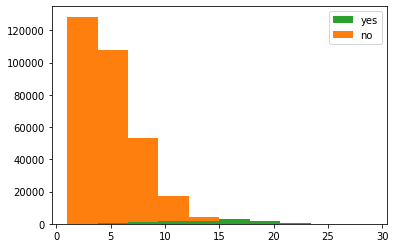

In [476]:
plt.hist(x = [data[data['converted']==1]['total_pages_visited'], data[data['converted']==0]['total_pages_visited']],
         stacked=True, color = ['tab:green','tab:orange'],label = ['yes','no'])

plt.legend()
plt.show()

- conversion (yes, no) vs country:

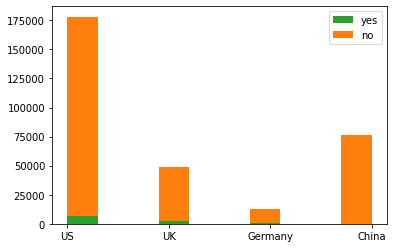

In [477]:
plt.hist(x = [data[data['converted']==1]['country'], data[data['converted']==0]['country']],
         stacked=True, color = ['tab:green','tab:orange'],label = ['yes','no'])
plt.legend()
plt.show()

- conversion (yes, no) vs age:

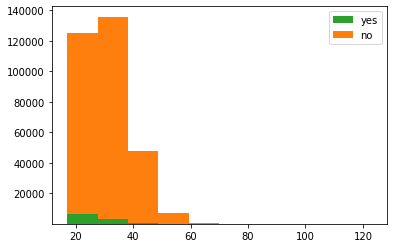

In [478]:
plt.hist(x = [data[data['converted']==1]['age'], data[data['converted']==0]['age']],
         stacked=True, color = ['tab:green','tab:orange'],label = ['yes','no'])
plt.legend()
plt.show()

- conversion (yes, no) vs new_user:

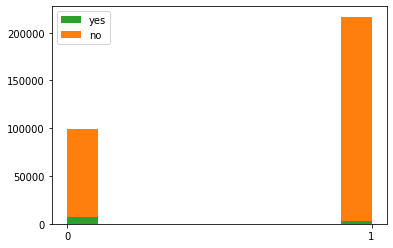

% of new users converted: 0.4588639131879083
% of non-new users converted: 2.1792953667953667


In [479]:
plt.hist(x = [data[data['converted']==1]['new_user'], data[data['converted']==0]['new_user']],
         stacked=True, color = ['tab:green','tab:orange'],label = ['yes','no'])
plt.xticks([0,1])

plt.legend()
plt.show()
converted_users = data.groupby('new_user')['converted'].count()
print("% of new users converted:", converted_users[0]/ data['new_user'].sum() )
print("% of non-new users converted:", converted_users[1]/(len(data['new_user'])- data['new_user'].sum()))


The conversion vs age plot suggests the presence of odd ages in the dataset, so I will
eliminate the rows where the age variable is greater than 100:

In [480]:
data_new = data[data['age'] < 100].reset_index()

I can now keep cleaning the data set, by transforming the object type columns via hot encoding,
and scaling the age and total_pages_visited columns (that otherwise would disproportionately influence the model).
I will not touch the columns that are already binary:

In [481]:
#First I create a list of the object-type column names:
scaler = MinMaxScaler()
obj_cols = []
to_scale = []
for col in data_new.columns:
    if data_new[col].dtype == 'object':
        obj_cols.append(col)
#Then I create a list of the columns to scale:
to_scale = ['age', 'total_pages_visited']

#I hot-encode the columns using get_dummies,
#scale the others via MinMaxScaler
#and finally I join the two resulting new databases with the old database 'new_user' and 'conversion'
# columns that on't need to be scaled.

scaled  = scaler.fit_transform(data_new[to_scale])
scaled_df = pd.DataFrame(scaled.astype(float), columns=to_scale).reset_index(drop=True)

one_hot = pd.get_dummies(data_new[obj_cols]).reset_index(drop=True)
processed_data = pd.concat([one_hot.astype(int),scaled_df] , axis = 1)
print(processed_data)
processed_data['converted'] = data_new['converted']
processed_data['new_user'] = data_new['new_user']

        country_China  country_Germany  country_UK  country_US  source_Ads  \
0                   0                0           1           0           1   
1                   0                0           0           1           0   
2                   0                0           0           1           0   
3                   1                0           0           0           0   
4                   0                0           0           1           0   
...               ...              ...         ...         ...         ...   
316193              0                0           0           1           1   
316194              0                0           0           1           0   
316195              1                0           0           0           1   
316196              0                0           0           1           0   
316197              0                0           1           0           1   

        source_Direct  source_Seo       age  total_pages_visite

# Modeling

I now can train a Logistic Regression model, using the Recall as metric to evaluate its success.
Before splitting the dataset in train and test data sets, I drop the object-type columns that have been hot-encoded and
have been used for data exploration, but will not be used for modeling purposes.

In [482]:
#Divide the dataset using the 'converted' columns as label and all the others as features.
X = processed_data.drop(columns=['converted'])
y = processed_data['converted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#Train the Logistic Regression classifier
clf = LogisticRegressionCV(cv=5, class_weight='balanced', max_iter = 2000, scoring = 'recall')
model = clf.fit(X_train, y_train)
res = model.predict(X_test)


print(metrics.recall_score(y_test, res))


KeyError: "['converted'] not found in axis"

I determine the features importances in order to give suggestions on how to increase conversion:

In [ ]:
#The features importances are the coefficients of the Logistic Regression model.
#I take the coefficients absolute values so that I can later sort them.
importances = abs(model.coef_)
tups = []

#I create a tuple with the feature name and its importance score, then I print them in descending order.
for i, v in enumerate(importances[0]):
	tups.append((X_train.columns[i], v))
tups.sort(key=lambda x:x[1], reverse=True)
for i in tups:
    print(i)


# Conclusions

- Marketing campaign in China should be re-assessed (as seen in the exploration, conversion is null).
- High number of total pages visited positively correlated to conversion: make website easier to navigate might increase the number of pages visited
- Returning users are more likely to convert. This might explain why Direct is the most important among the marketing channels?
- The conversion rate is higher in people aged 40 years old or less: make website easier to navigate for elderly people?